# Load Packages

In [ ]:
# Import packages
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import PIL
import pathlib
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.losses import *
import requests
!pip install pyunpack patool
import pyunpack
import matplotlib.pyplot as plt
from keras import backend as K
from keras.callbacks import ModelCheckpoint
import sys

!pip install rarfile segmentation-models git+https://github.com/davej23/image-segmentation-keras.git rioxarray
from rarfile import RarFile
import segmentation_models as sm
from keras_segmentation.models import segnet
from keras.applications import vgg16
from sklearn.metrics import *
import rioxarray as rxr
from tensorflow.keras.preprocessing.image import ImageDataGenerator

  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-m99tf3gf
  Running command git clone -q https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-m99tf3gf


In [ ]:
# Specify whether to download data or read in
download = True
base_dir = r"./Amazon Forest Dataset/"

In [ ]:
# Download data

if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data.rar').extractall('')

    else:
        with RarFile('data.rar') as rf:
            rf.extractall()

base_dir = r"./Amazon Forest Dataset/"

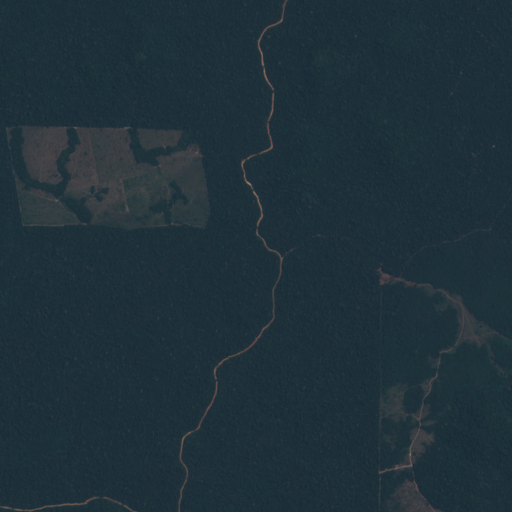

In [ ]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

In [ ]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification 
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction) 

In [ ]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [ ]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:   
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process RGB Dataset

In [ ]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [ ]:
# Pre-process data, normalise and reshape
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

In [ ]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [ ]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):
  
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [ ]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

In [ ]:
download = True # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [ ]:
# Download data (Amazon)

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images and normalise

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

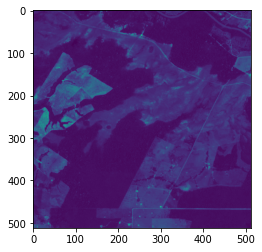

In [ ]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [ ]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

## 4-band Atlantic Forest dataset

In [ ]:
download = True # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Download data (Atlantic Forest)
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images and normalise

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [ ]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

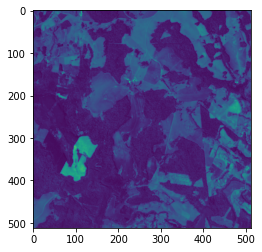

In [ ]:
# Plot example training image first band
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [ ]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv
  
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
# Print model layers and number of parameters
UNet().summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (1, 512, 512, 64)    1792        input_14[0][0]                   
__________________________________________________________________________________________________
activation_228 (Activation)     (1, 512, 512, 64)    0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 (Conv2D)              (1, 512, 512, 64)    36928       activation_228[0][0]             
___________________________________________________________________________________________

## Attention U-Net

In [ ]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv
  
'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
   
    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    upsample_psi = tf.broadcast_to(upsample_psi, shape=shape_x)
    y = multiply([upsample_psi, x])

    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           [(1, 512, 512, 3)]   0                                            
__________________________________________________________________________________________________
conv2d_69 (Conv2D)              (1, 512, 512, 16)    448         input_15[0][0]                   
__________________________________________________________________________________________________
activation_247 (Activation)     (1, 512, 512, 16)    0           conv2d_69[0][0]                  
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (1, 512, 512, 16)    2320        activation_247[0][0]             
___________________________________________________________________________________________

## ResNet50-SegNet

In [ ]:
# Forked code from: https://github.com/ykamikawa/tf-keras-SegNet

from keras.layers import Layer

'''
  Unpooling using max pooling indices
'''

class MaxPoolingWithArgmax2D(Layer):
    def __init__(self, pool_size=(2, 2), strides=(2, 2), padding="same", **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        padding = 'same'
        pool_size = (2,2)
        strides = (2,2)
        if K.backend() == "tensorflow":
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = K.tf.nn.max_pool_with_argmax(
                inputs, ksize=ksize, strides=strides, padding=padding
            )
        else:
            errmsg = "{} backend is not supported for layer {}".format(
                K.backend(), type(self).__name__
            )
            raise NotImplementedError(errmsg)
        argmax = K.cast(argmax, K.floatx())
        return [output, argmax]

class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        updates, mask = inputs[0], inputs[1]
        with tf.compat.v1.variable_scope(self.name):
            mask = K.cast(mask, "int32")
            input_shape = K.tf.shape(updates, out_type="int32")
            #  calculation new shape
            if output_shape is None:
                output_shape = (
                    input_shape[0],
                    input_shape[1] * self.size[0],
                    input_shape[2] * self.size[1],
                    input_shape[3],
                )
            self.output_shape1 = output_shape

            # calculation indices for batch, height, width and feature maps
            one_like_mask = K.ones_like(mask, dtype="int32")
            batch_shape = K.concatenate([[input_shape[0]], [1], [1], [1]], axis=0)
            batch_range = K.reshape(
                K.tf.range(output_shape[0], dtype="int32"), shape=batch_shape
            )
            b = one_like_mask * batch_range
            y = mask // (output_shape[2] * output_shape[3])
            x = (mask // output_shape[3]) % output_shape[2]
            feature_range = K.tf.range(output_shape[3], dtype="int32")
            f = one_like_mask * feature_range

            # transpose indices & reshape update values to one dimension
            updates_size = K.tf.size(updates)
            indices = K.transpose(K.reshape(K.stack([b, y, x, f]), [4, updates_size]))
            values = K.reshape(updates, [updates_size])
            ret = K.tf.scatter_nd(indices, values, output_shape)
            return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
            mask_shape[0],
            mask_shape[1] * self.size[0],
            mask_shape[2] * self.size[1],
            mask_shape[3],
        )

# Custom version of MaxUnpooling2D
# Takes raw layer values and outputs values
# Takes tf.nn.max_pool_with_argmax output as input
def unpool_with_indices(pool, indices, out_size=2):
  print(pool)
  print(indices)
  # Create empty array of appropriate size
  shape = np.array(np.shape(pool))
  shape = np.array((shape[0], out_size * shape[1], out_size * shape[2], shape[3]))
  out = np.zeros(shape)

  # Make upsample
  inds = np.array(indices).flatten()
  outs = np.array(pool).flatten()
  for i in range(len(inds)):
    blk = inds[i] // (shape[2] * shape[3]) # Find which block to place numbers in
    ln  = inds[i] - (blk * shape[3] * shape[2]) # Find which line
    ln2 = ln // (shape[3]) # Find line
    pos = ln % (shape[3]) # Find position
    #print(blk, ln2, pos)
    out[0][blk][ln2][pos] = outs[i]


  #print(out.shape)
  return (out)

# Own custom code
'''
  ResNet Contraction Phase Block
'''

def resnetConvDownBlock(x, filter, kernel, act='relu'):
  # Convolutional Block for encoding phase
  for i in range(3):
    x = ZeroPadding2D((1,1))(x)
    x = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(x)
    x = Activation('relu')(x)
    
  return x

'''
  SegNet Expansion Phase Block
'''
def resnetConvUpBlock(x, skip_connection = None, filter = None, kernel = None, act='relu'):
  # Convolutional block for decoding phase
  
  out = x

  # Unpooling
  out = UpSampling2D((2,2))(out)

  # Conv Block
  for i in range(3):
    out = ZeroPadding2D((1,1))(out)
    out = Conv2D(filters = filter, kernel_size = kernel, kernel_initializer = 'he_normal')(out)
    out = Activation('relu')(out)

  # Implement skip connection
  if skip_connection != None:
    out = Add()([out, skip_connection])

  return out

def ResNet50SegNet(input_size=(512,512,3), lr = 0.0001, filters = 64, kernel_sz = 3):

  inputs = Input(input_size)

  # Encoder
  # Conv, Conv, Conv, MaxPool #1
  block1 = resnetConvDownBlock(inputs, filter = filters, kernel = kernel_sz)
  pool1, mask1 = MaxPoolingWithArgmax2D((2,2))(block1)
  # Conv, Conv, Conv, MaxPool #2
  block2 = resnetConvDownBlock(pool1, filter = 2 * filters, kernel = kernel_sz)
  pool2, mask2 = MaxPoolingWithArgmax2D((2,2))(block2)
  # Conv, Conv, Conv, MaxPool #3
  block3 = resnetConvDownBlock(pool2, filter = 4 * filters, kernel = kernel_sz)
  pool3, mask3 = MaxPoolingWithArgmax2D((2,2))(block3)
  # Conv, Conv, Conv, MaxPool #4
  block4 = resnetConvDownBlock(pool3, filter = 8 * filters, kernel = kernel_sz)
  pool4, mask4 = MaxPoolingWithArgmax2D((2,2))(block4)
  # Conv, Conv, Conv, MaxPool #5
  block5 = resnetConvDownBlock(pool4, filter = 16 * filters, kernel = kernel_sz)
  pool5, mask5 = MaxPoolingWithArgmax2D((2,2))(block5)

  # Decoder
  # ConvTranspose + Concat, Conv, Conv, Conv #1
  block5_ = resnetConvUpBlock(pool5, filter = 16 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #2
  block4_ = resnetConvUpBlock(block5_, skip_connection = MaxUnpooling2D((2,2))([pool4, mask4]), filter = 8 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #3
  block3_ = resnetConvUpBlock(block4_, skip_connection = MaxUnpooling2D((2,2))([pool3, mask3]), filter = 4 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #4
  block2_ = resnetConvUpBlock(block3_, skip_connection = MaxUnpooling2D((2,2))([pool2, mask2]), filter = 2 * filters, kernel = kernel_sz)
  # ConvTranspose + Concat, Conv, Conv, Conv #5
  block1_ = resnetConvUpBlock(block2_, skip_connection = MaxUnpooling2D((2,2))([pool1, mask1]), filter = filters, kernel = kernel_sz)
  
  # Output
  outputs = Conv2D(1, kernel_size = 1, strides = 1, kernel_initializer = 'he_normal')(block1_)
  outputs = Activation('sigmoid')(outputs)

  model = Model(inputs, outputs)
  model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

  return model

In [ ]:
# Print model layers and number of parameters
ResNet50SegNet().summary()

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 514, 514, 3)  0           input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_100 (Conv2D)             (None, 512, 512, 64) 1792        zero_padding2d[0][0]             
__________________________________________________________________________________________________
activation_274 (Activation)     (None, 512, 512, 64) 0           conv2d_100[0][0]                 
___________________________________________________________________________________________

## FCN32-VGG16

In [ ]:
# Code forked and modified from: https://github.com/divamgupta/image-segmentation-keras

'''
  FCN32-VGG16 model
'''

def fcn_32(input_size = (512,512,3), lr = 0.0001, drop_rate = 0):
  
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    IMAGE_ORDERING = 'channels_last'
    # Input
    inputs = Input(shape=input_size)

    x = inputs
    levels = []

    ## Encoder
    # Block 1
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv1', data_format=IMAGE_ORDERING)(inputs)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same',
               name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 2
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same',
               name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 3
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same',
               name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 4
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool',
                     data_format=IMAGE_ORDERING)(x)
    levels.append(x)

    # Block 5
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same',
               name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool',
                     data_format=IMAGE_ORDERING)(x)

    levels.append(x)

    [f1, f2, f3, f4, f5] = levels

    o = f5

    # Decoder
    o = (Conv2D(4096, (7 , 7 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv6"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)
    o = (Conv2D(4096, (1 , 1 ), padding = 'same', kernel_initializer = 'he_normal', name = "conv7"))(o)
    o = Activation('relu')(o)
    o = Dropout(drop_rate)(o)

    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="scorer1"))(o)
    o = Conv2DTranspose(1, kernel_size=(64,64), padding='same', strides=(32,32), name="Upsample32")(o)
    o = (Conv2D(1, 1, padding='same', kernel_initializer='he_normal', name="output"))(o)

    # Output
    o = Activation('sigmoid')(o)

    model = Model(inputs, o)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])
    model.model_name = "fcn_32"
    return model

In [ ]:
# Print model layers and number of parameters
fcn_32().summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 512, 512, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 512, 512, 64)      1792      
_________________________________________________________________
activation_305 (Activation)  (None, 512, 512, 64)      0         
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 512, 512, 64)      36928     
_________________________________________________________________
activation_306 (Activation)  (None, 512, 512, 64)      0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 256, 256, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 256, 256, 128)     738

## ResUNet

In [ ]:
import tensorflow as tf

def res_block_initial(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer for first layer
    In the residual unet the first residual block does not contain an
    initial batch normalization and activation so we create this separate
    block for it.
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]
            
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                kernel_size=1,
                                strides=1,
                                padding='same',
                                kernel_initializer = 'he_normal',
                                name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)

    x1 = tf.keras.layers.Add()([x, x1])
    
    return x1

def res_block(x, num_filters, kernel_size, strides, name):
    """Residual Unet block layer
    Consists of batch norm and relu, folowed by conv, batch norm and relu and 
    final convolution. The input is then put through 
    Args:
        x: tensor, image or image activation
        num_filters: list, contains the number of filters for each subblock
        kernel_size: int, size of the convolutional kernel
        strides: list, contains the stride for each subblock convolution
        name: name of the layer
    Returns:
        x1: tensor, output from residual connection of x and x1
    """

    if len(num_filters) == 1:
        num_filters = [num_filters[0], num_filters[0]]

    #x1 = tf.keras.layers.BatchNormalization()(x)
    #x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Activation('relu')(x)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[0], 
                                kernel_size=kernel_size, 
                                strides=strides[0], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_1')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Activation('relu')(x1)
    x1 = tf.keras.layers.Conv2D(filters=num_filters[1], 
                                kernel_size=kernel_size,
                                strides=strides[1], 
                                padding='same', 
                                kernel_initializer = 'he_normal',
                                name=name+'_2')(x1)

    x = tf.keras.layers.Conv2D(filters=num_filters[-1],
                                    kernel_size=1,
                                    strides=strides[0],
                                    padding='same',
                                    kernel_initializer = 'he_normal',
                                    name=name+'_shortcut')(x)
    #x = tf.keras.layers.BatchNormalization()(x)
                                                            
    x1 = tf.keras.layers.Add()([x, x1])

    return x1


def upsample(x, target_size):
    """"Upsampling function, upsamples the feature map
    Deep Residual Unet paper does not describe the upsampling function 
    in detail. Original Unet uses a transpose convolution that downsamples 
    the number of feature maps. In order to restrict the number of 
    parameters here we use a bilinear resampling layer. This results in 
    the concatentation layer concatenting feature maps with n and n/2 
    features as opposed to n/2  and n/2 in the original unet.
    Args:
        x: tensor, feature map
        target_size: size to resize feature map to
    Returns:
        x_resized: tensor, upsampled feature map
    """

    x_resized = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, target_size))(x)

    return x_resized
        
def encoder(x, num_filters, kernel_size):
    """Unet encoder
    Args:
        x: tensor, output from previous layer
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        encoder_output: list, output from all encoder layers
    """

    x = res_block_initial(x, [num_filters[0]], kernel_size, strides=[1,1], name='layer1')

    encoder_output = [x]
    for i in range(1, len(num_filters)):
        layer = 'encoder_layer' + str(i)
        x = res_block(x, [num_filters[i]], kernel_size, strides=[2,1], name=layer)
        encoder_output.append(x)

    return encoder_output

def decoder(x, encoder_output, num_filters, kernel_size):
    """Unet decoder
    Args:
        x: tensor, output from previous layer
        encoder_output: list, output from all previous encoder layers
        num_filters: list, number of filters for each decoder layer
        kernel_size: int, size of the convolutional kernel
    Returns:
        x: tensor, output from last layer of decoder
    """

    for i in range(1, len(num_filters) + 1):
        layer = 'decoder_layer' + str(i)
        target_size = encoder_output[-i].shape[1:3]
        x = upsample(x, target_size)
        x = tf.keras.layers.Concatenate(axis=-1)([x, encoder_output[-i]])
        x = res_block(x, [num_filters[-i]], kernel_size, strides=[1,1], name=layer)

    return x


def res_unet(input_size, num_filters, kernel_size, num_channels, num_classes, lr = 0.0001, out_layer = 'sigmoid', lossfunc='binary_crossentropy', num_out=1):
    """Residual Unet
    Function that generates a residual unet
    Args:
        input_size: int, dimension of the input image
        num_layers: int, number of layers in the encoder half, excludes bridge
        num_filters: list, number of filters for each encoder layer
        kernel_size: size of the kernel, applied to all convolutions
        num_channels: int, number of channels for the input image
        num_classes: int, number of output classes for the output
    Returns:
        model: tensorflow keras model for residual unet architecture
    """

    x = tf.keras.Input(shape=[input_size, input_size, num_channels])

    encoder_output = encoder(x, num_filters, kernel_size)

    # bridge layer, number of filters is double that of the last encoder layer
    bridge = res_block(encoder_output[-1], [num_filters[-1]*2], kernel_size, 
                        strides=[2,1], name='bridge')

    decoder_output = decoder(bridge, encoder_output, num_filters, kernel_size)

    output = tf.keras.layers.Conv2D(num_classes, 
                                    kernel_size, 
                                    strides=1, 
                                    padding='same', 
                                    kernel_initializer = 'he_normal',
                                    name='output')(decoder_output)

    output = Activation(out_layer)(output)

    model = tf.keras.Model(x, output)
    model.compile(optimizer = adam_v2.Adam(learning_rate = lr), loss = lossfunc, metrics=['accuracy', 'mse'])

    return model

In [ ]:
res_unet(512, [64, 128, 256, 512], 3, 3, 1).summary()

Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
layer1_1 (Conv2D)               (None, 512, 512, 64) 1792        input_18[0][0]                   
__________________________________________________________________________________________________
activation_321 (Activation)     (None, 512, 512, 64) 0           layer1_1[0][0]                   
__________________________________________________________________________________________________
layer1_shortcut (Conv2D)        (None, 512, 512, 64) 256         input_18[0][0]                   
___________________________________________________________________________________________

# Train on RGB feature data

## U-Net

In [ ]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data = validation_df, callbacks=[save_model])

In [ ]:
# Save model training history
np.save('unet-3d-history.npy',model_unet.history.history)

In [ ]:
# Copy models to drive
!cp unet-3d.hdf5 drive/MyDrive/Diss/
!cp unet-3d-history.npy drive/MyDrive/Diss/

In [ ]:
# Plot accuracy and loss 

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

## Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('unet-attention-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

In [ ]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

In [ ]:
# Copy models to drive
!cp unet-attention-3d.hdf5 drive/MyDrive/Diss/
!cp unet-attention-3d-history.npy drive/MyDrive/Diss/

## ResNet50-SegNet

In [ ]:
R = ResNet50SegNet()
save_model_resnet = ModelCheckpoint('resnet50segnet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 40, steps_per_epoch = 100, callbacks=[save_model_resnet])

In [ ]:
# Save model history
np.save('resnet50segnet-3d-history.npy',R.history.history)

In [ ]:
# Copy models to drive
!cp resnet50segnet-3d.hdf5 drive/MyDrive/Diss/models/
!cp resnet50segnet-3d-history.npy drive/MyDrive/Diss/models/

## FCN32-VGG16

In [ ]:
F = fcn_32(lr = 0.0001)
save_model_fcn32 = ModelCheckpoint('fcn32-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
F.fit(train, validation_data = validation_df, epochs=50, steps_per_epoch = 100, shuffle = True, callbacks=[save_model_fcn32])

In [ ]:
# Save model history
np.save('fcn32-3d-history.npy', F.history.history)

In [ ]:
# Copy models to drive
!cp fcn32-3d.hdf5 drive/MyDrive/Diss/
!cp fcn32-3d-history.npy drive/MyDrive/Diss/

## ResUNet

In [ ]:
R = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
save_model_resunet = ModelCheckpoint('resunet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
R.fit(train, validation_data = validation_df, epochs = 40, steps_per_epoch = 100, callbacks=[save_model_resunet])

In [ ]:
# Save model history
np.save('resunet-3d-history.npy',R.history.history)

In [ ]:
# Copy models to drive
!cp resunet-3d.hdf5 drive/MyDrive/Diss/models/
!cp resunet-3d-history.npy drive/MyDrive/Diss/models/

# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band = UNet()
save_model_4band = ModelCheckpoint('unet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

In [ ]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

In [ ]:
# Copy models to drive
!cp unet-4d.hdf5 drive/MyDrive/Diss/
!cp unet-4d-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

In [ ]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

In [ ]:
# Copy models to drive
!cp unet-attention-4d.hdf5 drive/MyDrive/Diss/
!cp unet-attention-4d-history.npy drive/MyDrive/Diss/

### ResNet50-SegNet

In [ ]:
R_4band = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band = ModelCheckpoint('resnet50segnet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resnet_4band])

In [ ]:
# Save model history
np.save('resnet50segnet-4d-history.npy', R_4band.history.history)

In [ ]:
# Copy models to drive
!cp resnet50segnet-4d.hdf5 drive/MyDrive/Diss/models/
!cp resnet50segnet-4d-history.npy drive/MyDrive/Diss/models/

### FCN32-VGG16

In [ ]:
F_4band = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn_4band = ModelCheckpoint('fcn32-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 50, callbacks=[save_model_fcn_4band])

In [ ]:
# Save model history
np.save('fcn32-4d-history.npy', F_4band.history.history)

In [ ]:
# Copy models to drive
!cp fcn32-4d.hdf5 drive/MyDrive/Diss/
!cp fcn32-4d-history.npy drive/MyDrive/Diss/

### ResUNet

In [ ]:
R_4band = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
save_model_resunet_4band = ModelCheckpoint('resunet-4d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band.fit(train_df_4band_amazon, validation_data = validation_df_4band_amazon, epochs = 20, callbacks=[save_model_resunet_4band])

In [ ]:
# Save model history
np.save('resunet-4d-history.npy', R_4band.history.history)

In [ ]:
# Copy models to drive
!cp resunet-4d.hdf5 drive/MyDrive/Diss/models/
!cp resunet-4d-history.npy drive/MyDrive/Diss/models/

## Train on 4-band Atlantic data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet()
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

In [ ]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp unet-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp unet-4d-atlantic-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

In [ ]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp unet-attention-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp unet-attention-4d-atlantic-history.npy drive/MyDrive/Diss/

### ResNet50-SegNet

In [ ]:
R_4band_atlantic = ResNet50SegNet(input_size=(512,512,4))
save_model_resnet_4band_atlantic = ModelCheckpoint('resnet50segnet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resnet_4band_atlantic])

In [ ]:
# Save model history
np.save('resnet50segnet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp resnet50segnet-4d-atlantic.hdf5 drive/MyDrive/Diss/models/
!cp resnet50segnet-4d-history-atlantic.npy drive/MyDrive/Diss/models/

### FCN32-VGG16

In [ ]:
F_4band_atlantic = fcn_32(input_size=(512,512,4), lr = 0.0001)
save_model_fcn32_4band_atlantic = ModelCheckpoint('fcn32-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)
F_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 50, callbacks=[save_model_fcn32_4band_atlantic])

In [ ]:
# Save model history
np.save('fcn32-4d-atlantic-history.npy', F_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp fcn32-4d-atlantic.hdf5 drive/MyDrive/Diss/
!cp fcn32-4d-atlantic-history.npy drive/MyDrive/Diss/

### ResUNet

In [ ]:
R_4band_atlantic = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
save_model_resunet_4band_atlantic = ModelCheckpoint('resunet-4d-atlantic.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True, save_weights_only=True)
R_4band_atlantic.fit(train_df_4band_atlantic, validation_data = validation_df_4band_atlantic, epochs = 30, callbacks=[save_model_resunet_4band_atlantic])

In [ ]:
# Save model history
np.save('resunet-4d-history-atlantic.npy', R_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp resunet-4d-atlantic.hdf5 drive/MyDrive/Diss/models/
!cp resunet-4d-history-atlantic.npy drive/MyDrive/Diss/models/

# Import Models and Compute Metrics

## RGB

In [ ]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.hdf5')
unet = load_model('unet-3d.hdf5')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

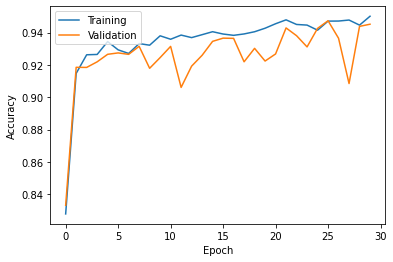

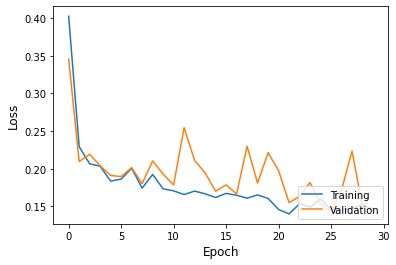

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_history['accuracy'])
plt.plot(unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')

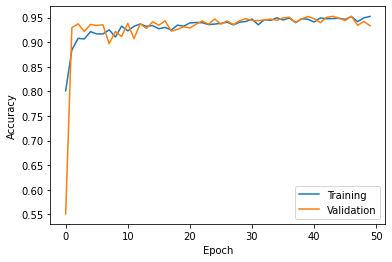

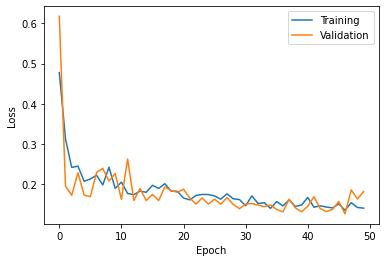

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [ ]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

In [ ]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

In [ ]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

U-Net accuracy:  0.9395044326782227 0.060767352361758925
Attention U-Net accuracy:  0.9447982788085938 0.04892808886792338


In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

U-Net precision:  0.9486444277859182 0.04976225221914376
Attention U-Net precision:  0.9469107065007807 0.05026890614161369


In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

U-Net recall:  0.9395044326782227 0.060767352361758925
Attention U-Net recall:  0.9447982788085938 0.04892808886792338


In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

U-Net F1-score:  0.944052308165236
Attention U-Net F1-score:  0.9458533132051024


## 4-band

### Amazon Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.hdf5')
unet_4d = load_model('unet-4d.hdf5')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

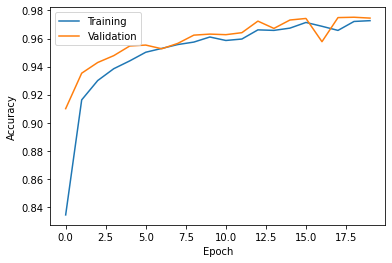

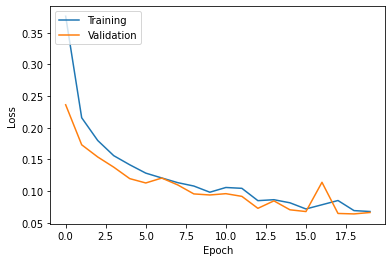

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

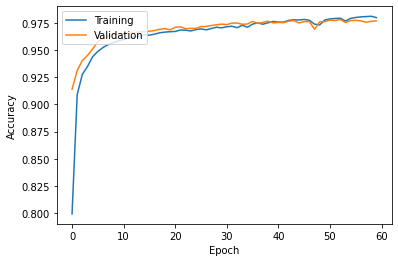

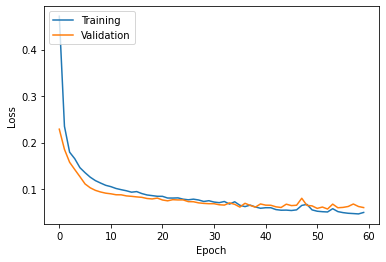

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

In [ ]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

U-Net accuracy:  0.975186424255371 0.022908675073541194
Attention U-Net accuracy:  0.9779380798339844 0.02111451450962175


In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.976647021383597 0.01991932006610463
Attention U-Net precision:  0.9790256930312505 0.019160716971491704


In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.975186424255371 0.022908675073541194
Attention U-Net recall:  0.9779380798339844 0.02111451450962175


In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

U-Net F1-score:  0.9759161763220419
Attention U-Net F1-score:  0.9784815842036025


### Amazon on unseen Atlantic data

In [ ]:
# Score
unet_amazon_on_atlantic_score = score_eval2(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
unet_amazon_on_atlantic_precision = (precision_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
unet_amazon_on_atlantic_recall = (recall_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(unet_amazon_on_atlantic_precision, unet_amazon_on_atlantic_recall))
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_amazon_on_atlantic_score), np.std(unet_amazon_on_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('U-Net precision: ', np.mean(unet_amazon_on_atlantic_precision), np.std(unet_amazon_on_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('U-Net recall: ', np.mean(unet_amazon_on_atlantic_recall), np.std(unet_amazon_on_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('U-Net F1-score: ', unet_amazon_on_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

U-Net score:  0.8846941947937011 0.08982562987777168
Attention U-Net score:  0.8828523953755697 0.10684353206781376
U-Net precision:  0.9168732192593768 0.04676348221428434
Attention U-Net precision:  0.9221976372319107 0.04420165970077992
U-Net recall:  0.8846941947937011 0.08982562987777168
Attention U-Net recall:  0.8828523953755697 0.10684353206781375
U-Net F1-score:  0.900496321273587
Attention U-Net F1-score:  0.9020962060135076


### Atlantic Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.hdf5')
unet_4d_atlantic = load_model('unet-4d-atlantic.hdf5')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

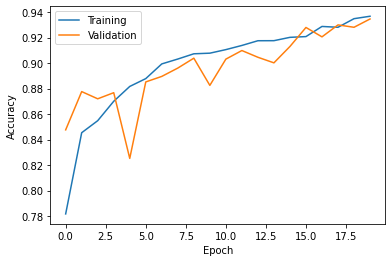

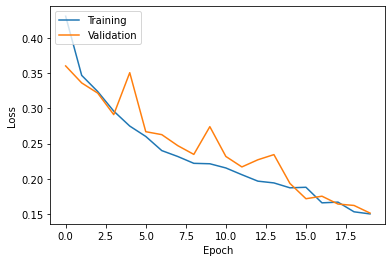

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

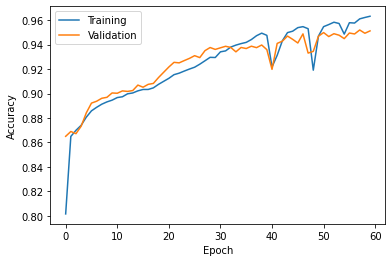

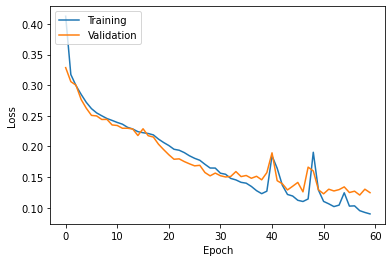

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_atlantic_score = (score_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision = (precision_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

unet_4d_atlantic_recall = (recall_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score = (f1_score_eval_basic(unet_4d_atlantic_precision, unet_4d_atlantic_recall))
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_4d_atlantic_score), np.std(unet_4d_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision), np.std(unet_4d_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall), np.std(unet_4d_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

U-Net score:  0.9346261596679688 0.052445221398208
Attention U-Net score:  0.9519517517089844 0.030166279074064023
U-Net precision:  0.9386773001618335 0.03641260419431297
Attention U-Net precision:  0.9563236733896407 0.021722305958663538
U-Net recall:  0.9346261596679688 0.052445221398208
Attention U-Net recall:  0.9519517517089844 0.030166279074064023
U-Net F1-score:  0.9366473494875831
Attention U-Net F1-score:  0.9541327044412243


### Atlantic on unseen Amazon data

In [ ]:
# Score
unet_atlantic_on_amazon_score = score_eval2(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
unet_atlantic_on_amazon_precision = (precision_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
unet_atlantic_on_amazon_recall = (recall_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(unet_atlantic_on_amazon_precision, unet_atlantic_on_amazon_recall))
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_atlantic_on_amazon_score), np.std(unet_atlantic_on_amazon_score))
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('U-Net precision: ', np.mean(unet_atlantic_on_amazon_precision), np.std(unet_atlantic_on_amazon_precision))
print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('U-Net recall: ', np.mean(unet_atlantic_on_amazon_recall), np.std(unet_atlantic_on_amazon_recall))
print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('U-Net F1-score: ', unet_atlantic_on_amazon_f1_score)
print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

U-Net score:  0.8915157000223796 0.0932127976762558
Attention U-Net score:  0.9266117413838705 0.05701273728830019
U-Net precision:  0.9323368415000753 0.046739859260368194
Attention U-Net precision:  0.9445315806544227 0.03958733603853125
U-Net recall:  0.8915157000223796 0.0932127976762558
Attention U-Net recall:  0.9266117413838705 0.05701273728830019
U-Net F1-score:  0.911469445016381
Attention U-Net F1-score:  0.9354858523492012


### Amazon and Atlantic unseen test data

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
unet_4d_score_test = (score_eval2(unet_4d, test_images2, test_masks2))
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
unet_4d_precision_test = (precision_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

unet_4d_recall_test = (recall_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
unet_4d_f1_score_test = (f1_score_eval_basic(unet_4d_precision_test, unet_4d_recall_test))
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
unet_4d_atlantic_score_test = (score_eval2(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision_test = (precision_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

unet_4d_atlantic_recall_test = (recall_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(unet_4d_atlantic_precision_test, unet_4d_atlantic_recall_test))
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('U-Net score: ', np.mean(unet_4d_score_test), np.std(unet_4d_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('U-Net precision: ', np.mean(unet_4d_precision_test), np.std(unet_4d_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('U-Net recall: ', np.mean(unet_4d_recall_test), np.std(unet_4d_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('U-Net F1-score: ', unet_4d_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

U-Net score:  0.9724159240722656 0.021293534825664956
Attention U-Net score:  0.9747537612915039 0.019844774736773
U-Net precision:  0.9738279305670721 0.018961125689019694
Attention U-Net precision:  0.9758240840110283 0.017958485345777382
U-Net recall:  0.9724159240722656 0.021293534825664956
Attention U-Net recall:  0.9747537612915039 0.019844774736773
U-Net F1-score:  0.9731214151119266
Attention U-Net F1-score:  0.9752886289970736


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('U-Net score: ', np.mean(unet_4d_atlantic_score_test), np.std(unet_4d_atlantic_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision_test), np.std(unet_4d_atlantic_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall_test), np.std(unet_4d_atlantic_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

U-Net score:  0.9373287200927735 0.052345346058224544
Attention U-Net score:  0.9570850372314453 0.01349322683924965
U-Net precision:  0.94243862353405 0.035933966482442785
Attention U-Net precision:  0.9590889631889826 0.0124338547954335
U-Net recall:  0.9373287200927735 0.052345346058224544
Attention U-Net recall:  0.9570850372314453 0.01349322683924965
U-Net F1-score:  0.9398767265089123
Attention U-Net F1-score:  0.9580859523619386


## ResNet50-SegNet

In [ ]:
# Load ResNet models and history stats
resnet_3d = ResNet50SegNet()
resnet_3d.load_weights('resnet50segnet-3d.hdf5')
resnet_4d_amazon = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_amazon.load_weights('resnet50segnet-4d.hdf5')
resnet_4d_atlantic = ResNet50SegNet(input_size=(512,512,4))
resnet_4d_atlantic.load_weights('resnet50segnet-4d-atlantic.hdf5')

resnet_3d_history = np.load('resnet50segnet-3d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_amazon_history = np.load('resnet50segnet-4d-history.npy', allow_pickle='TRUE').item()
resnet50segnet_4d_atlantic_history = np.load('resnet50segnet-4d-history-atlantic.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
resnet_3d_score = (score_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_score = (score_eval2(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_score = (score_eval2(resnet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resnet_3d_precision = (precision_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_precision = (precision_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_precision = (precision_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

resnet_3d_recall = (recall_eval(resnet_3d, validation_images, validation_masks))
resnet_4d_amazon_recall = (recall_eval(resnet_4d_amazon, validation_images2, validation_masks2))
resnet_4d_atlantic_recall = (recall_eval(resnet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resnet_3d_f1_score = (f1_score_eval_basic(resnet_3d_precision, resnet_3d_recall))
resnet_4d_amazon_f1_score = (f1_score_eval_basic(resnet_4d_amazon_precision, resnet_4d_amazon_recall))
resnet_4d_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_precision, resnet_4d_atlantic_recall))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resnet_4d_amazon_on_atlantic_score = (score_eval2(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_score = (score_eval2(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resnet_4d_amazon_on_atlantic_precision = (precision_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_precision = (precision_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resnet_4d_amazon_on_atlantic_recall = (recall_eval(resnet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resnet_4d_atlantic_on_amazon_recall = (recall_eval(resnet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resnet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resnet_4d_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_recall))
resnet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resnet_4d_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResNet 3-dim: ', np.mean(resnet_3d_score), np.mean(resnet_3d_precision), np.mean(resnet_3d_recall), resnet_3d_f1_score)
print('ResNet 3-dim: ', np.std(resnet_3d_score), np.std(resnet_3d_precision), np.std(resnet_3d_recall), resnet_3d_f1_score)
print('----')
print('ResNet 4-dim Amazon: ', np.mean(resnet_4d_amazon_score), np.mean(resnet_4d_amazon_precision), np.mean(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('ResNet 4-dim Amazon: ', np.std(resnet_4d_amazon_score), np.std(resnet_4d_amazon_precision), np.std(resnet_4d_amazon_recall), resnet_4d_amazon_f1_score)
print('----')
print('ResNet 4-dim Atlantic: ', np.mean(resnet_4d_atlantic_score), np.mean(resnet_4d_atlantic_precision), np.mean(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('ResNet 4-dim Atlantic: ', np.std(resnet_4d_atlantic_score), np.std(resnet_4d_atlantic_precision), np.std(resnet_4d_atlantic_recall), resnet_4d_atlantic_f1_score)
print('----')
print('ResNet 4-dim Amazon on Atlantic: ', np.mean(resnet_4d_amazon_on_atlantic_score), np.mean(resnet_4d_amazon_on_atlantic_precision), np.mean(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('ResNet 4-dim Amazon on Atlantic: ', np.std(resnet_4d_amazon_on_atlantic_score), np.std(resnet_4d_amazon_on_atlantic_precision), np.std(resnet_4d_amazon_on_atlantic_recall), resnet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResNet 4-dim Atlantic on Amazon: ', np.mean(resnet_4d_atlantic_on_amazon_score), np.mean(resnet_4d_atlantic_on_amazon_precision), np.mean(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)
print('ResNet 4-dim Atlantic on Amazon: ', np.std(resnet_4d_atlantic_on_amazon_score), np.std(resnet_4d_atlantic_on_amazon_precision), np.std(resnet_4d_atlantic_on_amazon_recall), resnet_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
ResNet 3-dim:  0.9447669982910156 0.949842512274315 0.9447669982910156 0.9472979568257667
ResNet 3-dim:  0.054819042888917174 0.0476922480720874 0.054819042888917174 0.9472979568257667
----
ResNet 4-dim Amazon:  0.9717498397827149 0.9733257837688449 0.9717498397827149 0.9725371733431614
ResNet 4-dim Amazon:  0.023450585104448734 0.02046346591517085 0.023450585104448734 0.9725371733431614
----
ResNet 4-dim Atlantic:  0.947955093383789 0.9513523840356695 0.947955093383789 0.9496507003434008
ResNet 4-dim Atlantic:  0.027626663710908578 0.022244210836913223 0.027626663710908578 0.9496507003434008
----
ResNet 4-dim Amazon on Atlantic:  0.8669666608174642 0.915592527163881 0.8669666608174642 0.890616369202996
ResNet 4-dim Amazon on Atlantic:  0.11444763701614054 0.04198269756948197 0.11444763701614054 0.890616369202996
----
ResNet 4-dim Atlantic on Amazon:  0.9087992350260417 0.9355350272526637 0.9087992350260417 0.9219733477778967
ResNet 4-dim Atlant

### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
resnet_4d_score_test = (score_eval2(resnet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resnet_4d_precision_test = (precision_eval(resnet_4d_amazon, test_images2, test_masks2))
resnet_4d_recall_test = (recall_eval(resnet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resnet_4d_f1_score_test = (f1_score_eval_basic(resnet_4d_precision_test, resnet_4d_recall_test))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resnet_4d_atlantic_score_test = (score_eval2(resnet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resnet_4d_atlantic_precision_test = (precision_eval(resnet_4d_atlantic, test_images3, test_masks3))
resnet_4d_atlantic_recall_test = (recall_eval(resnet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resnet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resnet_4d_atlantic_precision_test, resnet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('ResNet score: ', np.mean(resnet_4d_score_test), np.std(resnet_4d_score_test))
print('ResNet precision: ', np.mean(resnet_4d_precision_test), np.std(resnet_4d_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_recall_test), np.std(resnet_4d_recall_test))
print('ResNet F1-score: ', resnet_4d_f1_score_test)

ResNet score:  0.969398307800293 0.021191613151098125
ResNet precision:  0.9707419790017067 0.01862770122766578
ResNet recall:  0.969398307800293 0.021191613151098125
ResNet F1-score:  0.970069678111889


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('ResNet score: ', np.mean(resnet_4d_atlantic_score_test), np.std(resnet_4d_atlantic_score_test))
print('ResNet precision: ', np.mean(resnet_4d_atlantic_precision_test), np.std(resnet_4d_atlantic_precision_test))
print('ResNet recall: ', np.mean(resnet_4d_atlantic_recall_test), np.std(resnet_4d_atlantic_recall_test))
print('ResNet F1-score: ', resnet_4d_atlantic_f1_score_test)

ResNet score:  0.9465770721435547 0.02797195602803041
ResNet precision:  0.9510178513149313 0.019663765108312733
ResNet recall:  0.9465770721435547 0.02797195602803041
ResNet F1-score:  0.9487922655413198


## FCN32-VGG16

In [ ]:
# Import models
fcn32_3d = load_model('fcn32-3d.hdf5')
fcn32_4d_amazon = load_model('fcn32-4d.hdf5')
fcn32_4d_atlantic = load_model('fcn32-4d-atlantic.hdf5')

fcn32_3d_history = np.load('fcn32-3d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_amazon_history = np.load('fcn32-4d-history.npy', allow_pickle='TRUE').item()
fcn32_4d_atlantic_history = np.load('fcn32-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
fcn32_3d_score = (score_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_score = (score_eval2(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_score = (score_eval2(fcn32_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
fcn32_3d_precision = (precision_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_precision = (precision_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_precision = (precision_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

fcn32_3d_recall = (recall_eval(fcn32_3d, validation_images, validation_masks))
fcn32_4d_amazon_recall = (recall_eval(fcn32_4d_amazon, validation_images2, validation_masks2))
fcn32_4d_atlantic_recall = (recall_eval(fcn32_4d_atlantic, validation_images3, validation_masks3))

# F1-score
fcn32_3d_f1_score = (f1_score_eval_basic(fcn32_3d_precision, fcn32_3d_recall))
fcn32_4d_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_precision, fcn32_4d_amazon_recall))
fcn32_4d_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_precision, fcn32_4d_atlantic_recall))

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
fcn32_4d_amazon_on_atlantic_score = (score_eval2(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_score = (score_eval2(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
fcn32_4d_amazon_on_atlantic_precision = (precision_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_precision = (precision_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

fcn32_4d_amazon_on_atlantic_recall = (recall_eval(fcn32_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
fcn32_4d_atlantic_on_amazon_recall = (recall_eval(fcn32_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
fcn32_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(fcn32_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_recall))
fcn32_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(fcn32_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('FCN32 3-dim: ', np.mean(fcn32_3d_score), np.mean(fcn32_3d_precision), np.mean(fcn32_3d_recall), fcn32_3d_f1_score)
print('FCN32 3-dim: ', np.std(fcn32_3d_score), np.std(fcn32_3d_precision), np.std(fcn32_3d_recall), fcn32_3d_f1_score)
print('----')
print('FCN32 4-dim Amazon: ', np.mean(fcn32_4d_amazon_score), np.mean(fcn32_4d_amazon_precision), np.mean(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('FCN32 4-dim Amazon: ', np.std(fcn32_4d_amazon_score), np.std(fcn32_4d_amazon_precision), np.std(fcn32_4d_amazon_recall), fcn32_4d_amazon_f1_score)
print('----')
print('FCN32 4-dim Atlantic: ', np.mean(fcn32_4d_atlantic_score), np.mean(fcn32_4d_atlantic_precision), np.mean(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('FCN32 4-dim Atlantic: ', np.std(fcn32_4d_atlantic_score), np.std(fcn32_4d_atlantic_precision), np.std(fcn32_4d_atlantic_recall), fcn32_4d_atlantic_f1_score)
print('----')
print('FCN32 4-dim Amazon on Atlantic: ', np.mean(fcn32_4d_amazon_on_atlantic_score), np.mean(fcn32_4d_amazon_on_atlantic_precision), np.mean(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('FCN32 4-dim Amazon on Atlantic: ', np.std(fcn32_4d_amazon_on_atlantic_score), np.std(fcn32_4d_amazon_on_atlantic_precision), np.std(fcn32_4d_amazon_on_atlantic_recall), fcn32_4d_amazon_on_atlantic_f1_score)
print('----')
print('FCN32 4-dim Atlantic on Amazon: ', np.mean(fcn32_4d_atlantic_on_amazon_score), np.mean(fcn32_4d_atlantic_on_amazon_precision), np.mean(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)
print('FCN32 4-dim Atlantic on Amazon: ', np.std(fcn32_4d_atlantic_on_amazon_score), np.std(fcn32_4d_atlantic_on_amazon_precision), np.std(fcn32_4d_atlantic_on_amazon_recall), fcn32_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
FCN32 3-dim:  0.8990402221679688 0.899287494932274 0.8990402221679688 0.8991638415499329
FCN32 3-dim:  0.068574559760974 0.06724606296130786 0.068574559760974 0.8991638415499329
----
FCN32 4-dim Amazon:  0.9213930892944336 0.9210134174757392 0.9213930892944336 0.9212032142648678
FCN32 4-dim Amazon:  0.04291320299377885 0.040370754139303876 0.04291320299377885 0.9212032142648678
----
FCN32 4-dim Atlantic:  0.8289618301391601 0.8318560616728573 0.8289618301391601 0.830406424083414
FCN32 4-dim Atlantic:  0.06030173569369432 0.05248833451508506 0.06030173569369432 0.830406424083414
----
FCN32 4-dim Amazon on Atlantic:  0.7929514249165853 0.8246112433297971 0.7929514249165853 0.8084715025099765
FCN32 4-dim Amazon on Atlantic:  0.10942310774412778 0.05767176731078699 0.10942310774412778 0.8084715025099765
----
FCN32 4-dim Atlantic on Amazon:  0.8749940236409505 0.8985221083094259 0.8749940236409505 0.8866020000792558
FCN32 4-dim Atlantic on Amazon:  0

### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
fcn32_4d_score_test = (score_eval2(fcn32_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
fcn32_4d_precision_test = (precision_eval(fcn32_4d_amazon, test_images2, test_masks2))
fcn32_4d_recall_test = (recall_eval(fcn32_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
fcn32_4d_f1_score_test = (f1_score_eval_basic(fcn32_4d_precision_test, fcn32_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
fcn32_4d_atlantic_score_test = (score_eval2(fcn32_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
fcn32_4d_atlantic_precision_test = (precision_eval(fcn32_4d_atlantic, test_images3, test_masks3))
fcn32_4d_atlantic_recall_test = (recall_eval(fcn32_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
fcn32_4d_atlantic_f1_score_test = (f1_score_eval_basic(fcn32_4d_atlantic_precision_test, fcn32_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('FCN32 score: ', np.mean(fcn32_4d_score_test), np.std(fcn32_4d_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_precision_test), np.std(fcn32_4d_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_recall_test), np.std(fcn32_4d_recall_test))
print('FCN32 F1-score: ', fcn32_4d_f1_score_test)

FCN32 score:  0.9204916000366211 0.031370949917089476
FCN32 precision:  0.9211980700523019 0.029419851109199802
FCN32 recall:  0.9204916000366211 0.031370949917089476
FCN32 F1-score:  0.9208446995439232


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('FCN32 score: ', np.mean(fcn32_4d_atlantic_score_test), np.std(fcn32_4d_atlantic_score_test))
print('FCN32 precision: ', np.mean(fcn32_4d_atlantic_precision_test), np.std(fcn32_4d_atlantic_precision_test))
print('FCN32 recall: ', np.mean(fcn32_4d_atlantic_recall_test), np.std(fcn32_4d_atlantic_recall_test))
print('FCN32 F1-score: ', fcn32_4d_atlantic_f1_score_test)

FCN32 score:  0.8076549530029297 0.08254624208056893
FCN32 precision:  0.8185838777023733 0.055060819401567436
FCN32 recall:  0.8076549530029297 0.08254624208056893
FCN32 F1-score:  0.8130826921503669


## ResUNet

In [ ]:
# Load ResUNet models and history stats
# Import models
resunet_3d = res_unet(512, [64, 128, 256, 512], 3, 3, 1)
resunet_4d_amazon = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_4d_atlantic = res_unet(512, [64, 128, 256, 512], 3, 4, 1)
resunet_3d.load_weights('resunet-3d.hdf5')
resunet_4d_amazon.load_weights('resunet-4d.hdf5')
resunet_4d_atlantic.load_weights('resunet-4d-atlantic.hdf5')

resunet_3d_history = np.load('resunet-3d-history.npy', allow_pickle='TRUE').item()
resunet_4d_amazon_history = np.load('resunet-4d-history.npy', allow_pickle='TRUE').item()
resunet_4d_atlantic_history = np.load('resunet-4d-atlantic-history.npy', allow_pickle='TRUE').item()

In [ ]:
# Metrics of each model on respective datasets

# Score
resunet_3d_score = (score_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_score = (score_eval2(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_score = (score_eval2(resunet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall
resunet_3d_precision = (precision_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_precision = (precision_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_precision = (precision_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

resunet_3d_recall = (recall_eval(resunet_3d, validation_images, validation_masks))
resunet_4d_amazon_recall = (recall_eval(resunet_4d_amazon, validation_images2, validation_masks2))
resunet_4d_atlantic_recall = (recall_eval(resunet_4d_atlantic, validation_images3, validation_masks3))

# F1-score
resunet_3d_f1_score = (f1_score_eval_basic(resunet_3d_precision, resnet_3d_recall))
resunet_4d_amazon_f1_score = (f1_score_eval_basic(resunet_4d_amazon_precision, resnet_4d_amazon_recall))
resunet_4d_atlantic_f1_score = (f1_score_eval_basic(resunet_4d_atlantic_precision, resnet_4d_atlantic_recall))

In [ ]:
# Metrics of 4-dim Amazon trained model on Atlantic data and vice versa

# Score
resunet_4d_amazon_on_atlantic_score = (score_eval2(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_score = (score_eval2(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Precision and recall
resunet_4d_amazon_on_atlantic_precision = (precision_eval(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_precision = (precision_eval(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

resunet_4d_amazon_on_atlantic_recall = (recall_eval(resunet_4d_amazon, validation_images3+test_images3, validation_masks3+test_masks3))
resunet_4d_atlantic_on_amazon_recall = (recall_eval(resunet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-score
resunet_4d_amazon_on_atlantic_f1_score = (f1_score_eval_basic(resunet_4d_amazon_on_atlantic_precision, resunet_4d_amazon_on_atlantic_recall))
resunet_4d_atlantic_on_amazon_f1_score = (f1_score_eval_basic(resunet_4d_atlantic_on_amazon_precision, resunet_4d_atlantic_on_amazon_recall))

In [ ]:
# Print metrics
print('Accuracy | Precision | Recall | F1-score')
print('ResUNet 3-dim: ', np.mean(resunet_3d_score), np.mean(resunet_3d_precision), np.mean(resunet_3d_recall), resunet_3d_f1_score)
print('ResUNet 3-dim: ', np.std(resunet_3d_score), np.std(resunet_3d_precision), np.std(resunet_3d_recall), resunet_3d_f1_score)
print('----')
print('ResUNet 4-dim Amazon: ', np.mean(resunet_4d_amazon_score), np.mean(resunet_4d_amazon_precision), np.mean(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
print('ResUNet 4-dim Amazon: ', np.std(resunet_4d_amazon_score), np.std(resunet_4d_amazon_precision), np.std(resunet_4d_amazon_recall), resunet_4d_amazon_f1_score)
print('----')
print('ResUNet 4-dim Atlantic: ', np.mean(resunet_4d_atlantic_score), np.mean(resunet_4d_atlantic_precision), np.mean(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
print('ResUNet 4-dim Atlantic: ', np.std(resunet_4d_atlantic_score), np.std(resunet_4d_atlantic_precision), np.std(resunet_4d_atlantic_recall), resunet_4d_atlantic_f1_score)
print('----')
print('ResUNet 4-dim Amazon on Atlantic: ', np.mean(resunet_4d_amazon_on_atlantic_score), np.mean(resunet_4d_amazon_on_atlantic_precision), np.mean(resunet_4d_amazon_on_atlantic_recall), resunet_4d_amazon_on_atlantic_f1_score)
print('ResUNet 4-dim Amazon on Atlantic: ', np.std(resunet_4d_amazon_on_atlantic_score), np.std(resunet_4d_amazon_on_atlantic_precision), np.std(resunet_4d_amazon_on_atlantic_recall), resunet_4d_amazon_on_atlantic_f1_score)
print('----')
print('ResUNet 4-dim Atlantic on Amazon: ', np.mean(resunet_4d_atlantic_on_amazon_score), np.mean(resunet_4d_atlantic_on_amazon_precision), np.mean(resunet_4d_atlantic_on_amazon_recall), resunet_4d_atlantic_on_amazon_f1_score)
print('ResUNet 4-dim Atlantic on Amazon: ', np.std(resunet_4d_atlantic_on_amazon_score), np.std(resunet_4d_atlantic_on_amazon_precision), np.std(resunet_4d_atlantic_on_amazon_recall), resunet_4d_atlantic_on_amazon_f1_score)


Accuracy | Precision | Recall | F1-score
ResUNet 3-dim:  0.9505455017089843 0.9539338234567148 0.9505455017089843 0.94932828240511
ResUNet 3-dim:  0.05274510731916556 0.04984496434377861 0.05274510731916556 0.94932828240511
----
ResUNet 4-dim Amazon:  0.9696456909179687 0.9723141998556664 0.9696456909179687 0.9720319379025754
ResUNet 4-dim Amazon:  0.026561001141943614 0.021216112065652486 0.026561001141943614 0.9720319379025754
----
ResUNet 4-dim Atlantic:  0.9514009475708007 0.9544179564768797 0.9514009475708007 0.9511755469049246
ResUNet 4-dim Atlantic:  0.028136986032262466 0.022731503649715396 0.028136986032262466 0.9511755469049246
----
ResUNet 4-dim Amazon on Atlantic:  0.8507696469624837 0.9163905463693262 0.8507696469624837 0.8823617287852761
ResUNet 4-dim Amazon on Atlantic:  0.13019036178567991 0.03878038803453958 0.13019036178567991 0.8823617287852761
----
ResUNet 4-dim Atlantic on Amazon:  0.9256286938985189 0.9440473702766555 0.9256286938985189 0.9347473084467323
ResUNet 

### Amazon and Atlantic unseen test datasets

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
resunet_4d_score_test = (score_eval2(resunet_4d_amazon, test_images2, test_masks2))

# Precision and recall of each model
resunet_4d_precision_test = (precision_eval(resunet_4d_amazon, test_images2, test_masks2))
resunet_4d_recall_test = (recall_eval(resunet_4d_amazon, test_images2, test_masks2))

# F1-scores of each model
resunet_4d_f1_score_test = (f1_score_eval_basic(resunet_4d_precision_test, resunet_4d_recall_test))

In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
resunet_4d_atlantic_score_test = (score_eval2(resunet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
resunet_4d_atlantic_precision_test = (precision_eval(resunet_4d_atlantic, test_images3, test_masks3))
resunet_4d_atlantic_recall_test = (recall_eval(resunet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
resunet_4d_atlantic_f1_score_test = (f1_score_eval_basic(resunet_4d_atlantic_precision_test, resunet_4d_atlantic_recall_test))

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('ResUNet score: ', np.mean(resunet_4d_score_test), np.std(resunet_4d_score_test))
print('ResUNet precision: ', np.mean(resunet_4d_precision_test), np.std(resunet_4d_precision_test))
print('ResUNet recall: ', np.mean(resunet_4d_recall_test), np.std(resunet_4d_recall_test))
print('ResUNet F1-score: ', resunet_4d_f1_score_test)

ResUNet score:  0.9702981948852539 0.01806097940966505
ResUNet precision:  0.9714956586338486 0.016575870027892747
ResUNet recall:  0.9702981948852539 0.01806097940966505
ResUNet F1-score:  0.9708965575340984


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('ResUNet score: ', np.mean(resunet_4d_atlantic_score_test), np.std(resunet_4d_atlantic_score_test))
print('ResUNet precision: ', np.mean(resunet_4d_atlantic_precision_test), np.std(resunet_4d_atlantic_precision_test))
print('ResUNet recall: ', np.mean(resunet_4d_atlantic_recall_test), np.std(resunet_4d_atlantic_recall_test))
print('ResUNet F1-score: ', resunet_4d_atlantic_f1_score_test)

ResUNet score:  0.9492748260498047 0.03074646469617859
ResUNet precision:  0.9541603619169482 0.020414605594031514
ResUNet recall:  0.9492748260498047 0.03074646469617859
ResUNet F1-score:  0.9517113241453331


# Produce metric datasets for export

## RGB data

In [ ]:
scores_3d = [unet_score, am_unet_score, resnet_3d_score, fcn32_3d_score, resunet_3d_score]
precision_3d = [unet_precision, am_unet_precision, resnet_3d_precision, fcn32_3d_precision, resunet_3d_precision]
recall_3d = [unet_recall, am_unet_recall, resnet_3d_recall, fcn32_3d_recall, resunet_3d_recall]
f1_scores_3d = [unet_f1_score, am_unet_f1_score, resnet_3d_f1_score, fcn32_3d_f1_score, resunet_3d_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)
metrics_3d.to_csv('metrics_3d.csv')

## 4-band Amazon data

In [ ]:
scores_4d = [unet_4d_score, am_unet_4d_score, resnet_4d_amazon_score, fcn32_4d_amazon_score, resunet_4d_amazon_score]
precision_4d = [unet_4d_precision, am_unet_4d_precision, resnet_4d_amazon_precision, fcn32_4d_amazon_precision, resunet_4d_amazon_precision]
recall_4d = [unet_4d_recall, am_unet_4d_recall, resnet_4d_amazon_recall, fcn32_4d_amazon_recall, resunet_4d_amazon_recall]
f1_scores_4d = [unet_4d_f1_score, am_unet_4d_f1_score, resnet_4d_amazon_f1_score, fcn32_4d_amazon_f1_score, resunet_4d_amazon_f1_score]

metrics_4d = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_4d_amazon.csv')

## 4-band Atlantic Forest data

In [ ]:
scores_4d_atl = [unet_4d_atlantic_score, am_unet_4d_atlantic_score, resnet_4d_atlantic_score, fcn32_4d_atlantic_score, resunet_4d_atlantic_score]
precision_4d_atl = [unet_4d_atlantic_precision, am_unet_4d_atlantic_precision, resnet_4d_atlantic_precision, fcn32_4d_atlantic_precision, resunet_4d_atlantic_precision]
recall_4d_atl = [unet_4d_atlantic_recall, am_unet_4d_atlantic_recall, resnet_4d_atlantic_recall, fcn32_4d_atlantic_recall, resunet_4d_atlantic_recall]
f1_scores_4d_atl = [unet_4d_atlantic_f1_score, am_unet_4d_atlantic_f1_score, resnet_4d_atlantic_f1_score, fcn32_4d_atlantic_f1_score, resunet_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_4d_atlantic_forest.csv')

## Test set data

In [ ]:
scores_4d_test = [unet_4d_score_test, am_unet_4d_score_test, resnet_4d_score_test, fcn32_4d_score_test, resunet_4d_score_test]
precision_4d_test = [unet_4d_precision_test, am_unet_4d_precision_test, resnet_4d_precision_test, fcn32_4d_precision_test, resunet_4d_precision_test]
recall_4d_test = [unet_4d_recall_test, am_unet_4d_recall_test, resnet_4d_recall_test, fcn32_4d_recall_test, resunet_4d_recall_test]
f1_scores_4d_test = [unet_4d_f1_score_test, am_unet_4d_f1_score_test, resnet_4d_f1_score_test, fcn32_4d_f1_score_test, resunet_4d_f1_score_test]

metrics_4d_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_4d_amazon_test.csv')

In [ ]:
scores_4d_atl_test = [unet_4d_atlantic_score_test, am_unet_4d_atlantic_score_test, resnet_4d_atlantic_score_test, fcn32_4d_atlantic_score_test, resunet_4d_atlantic_score_test]
precision_4d_atl_test = [unet_4d_atlantic_precision_test, am_unet_4d_atlantic_precision_test, resnet_4d_atlantic_precision_test, fcn32_4d_atlantic_precision_test, resunet_4d_atlantic_precision_test]
recall_4d_atl_test = [unet_4d_atlantic_recall_test, am_unet_4d_atlantic_recall_test, resnet_4d_atlantic_recall_test, fcn32_4d_atlantic_recall_test, resunet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [unet_4d_atlantic_f1_score_test, am_unet_4d_atlantic_f1_score_test, resnet_4d_atlantic_f1_score_test, fcn32_4d_atlantic_f1_score_test, resunet_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_4d_atlantic_forest_test.csv')

## Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [ ]:
scores_amazon_on_atlantic = [unet_amazon_on_atlantic_score, am_unet_amazon_on_atlantic_score, resnet_4d_amazon_on_atlantic_score, fcn32_4d_amazon_on_atlantic_score, resunet_4d_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_precision, resnet_4d_amazon_on_atlantic_precision, fcn32_4d_amazon_on_atlantic_precision, resunet_4d_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [unet_amazon_on_atlantic_recall, am_unet_amazon_on_atlantic_recall, resnet_4d_amazon_on_atlantic_recall, fcn32_4d_amazon_on_atlantic_recall, resunet_4d_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [unet_amazon_on_atlantic_f1_score, am_unet_amazon_on_atlantic_f1_score, resnet_4d_amazon_on_atlantic_f1_score, fcn32_4d_amazon_on_atlantic_f1_score, resunet_4d_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_4d_amazon_on_atlantic.csv')

In [ ]:
scores_atlantic_on_amazon = [unet_atlantic_on_amazon_score, am_unet_atlantic_on_amazon_score, resnet_4d_atlantic_on_amazon_score, fcn32_4d_atlantic_on_amazon_score, resunet_4d_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_precision, resnet_4d_atlantic_on_amazon_precision, fcn32_4d_atlantic_on_amazon_precision, resunet_4d_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [unet_atlantic_on_amazon_recall, am_unet_atlantic_on_amazon_recall, resnet_4d_atlantic_on_amazon_recall, fcn32_4d_atlantic_on_amazon_recall, resunet_4d_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [unet_atlantic_on_amazon_f1_score, am_unet_atlantic_on_amazon_f1_score, resnet_4d_atlantic_on_amazon_f1_score, fcn32_4d_atlantic_on_amazon_f1_score, resunet_4d_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['U-Net', 'Attention U-Net', 'ResNet50-SegNet', 'FCN32-VGG16', 'ResUNet'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_4d_atlantic_on_amazon.csv')